<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Performance metric for supervised learning:  
- Both precision and recall are important, hence F1 score is good choice
- Confusion matrix

In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

In [2]:
#reading graph, run this cell 2 times atleast
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


> Displaying a sub graph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


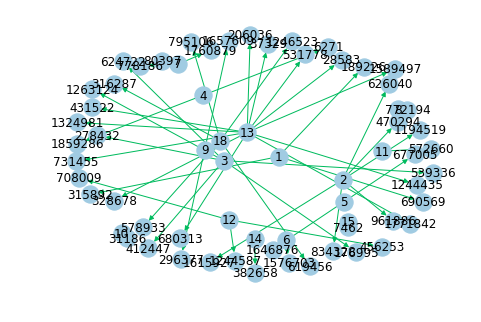

In [3]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
# Drawing a graph : https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [4]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No of followers for each person

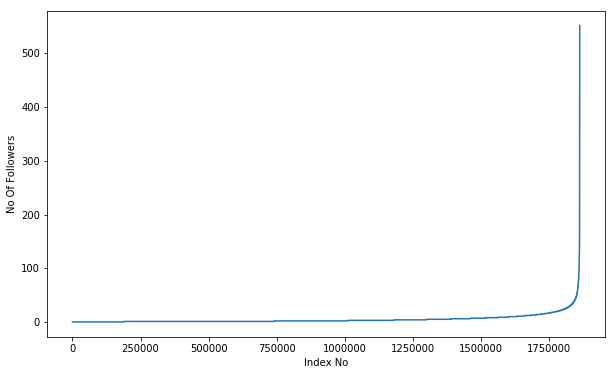

In [5]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

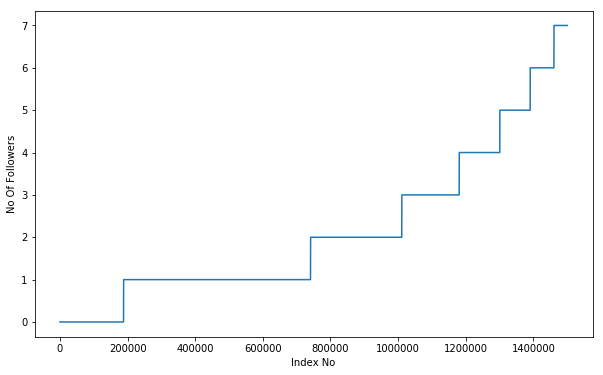

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In [8]:
### 90-100 percentile

for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of people having 40 or fewer followers.

## 1.2 No of people each person is following

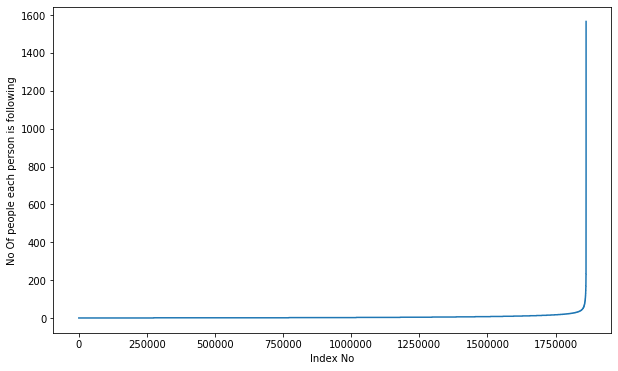

In [3]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

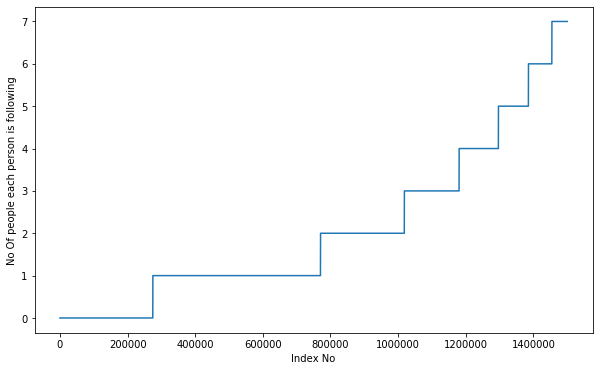

In [4]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [5]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [6]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


In [7]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [18]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


## 1.3 both followers + following 

In [20]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

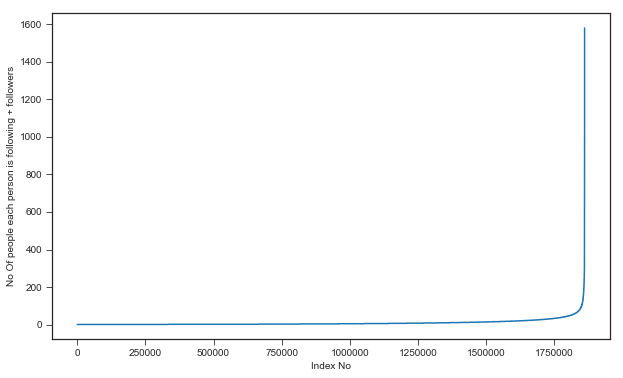

In [21]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

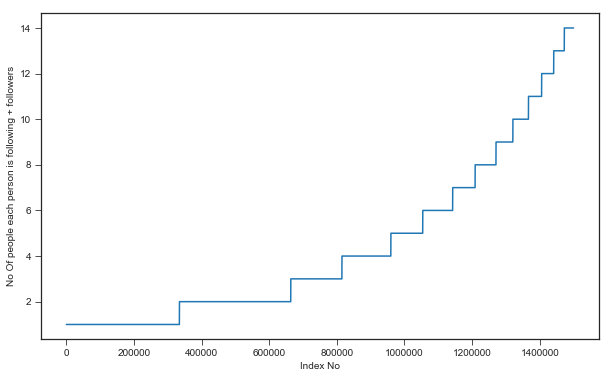

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [23]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


# 2. Posing a problem as a classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generate links from graph which are not in graph and whose shortest path is greater than 2,
as to classify it as ML problem we r proposing it as class 1 if edges is present, else not present

>From the set of all the possible edges, we take a small random sample, between which there could exist an edge, but there is no edges

In [46]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            if nx.shortest_path_length(g,source=a,target=b) > 2: 
                missing_edges.add((a,b))
            else:
                continue             
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.pkl','wb'))
else:    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.pkl','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.pkl','rb'))

    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.pkl','rb'))
    

Wall time: 5.08 s


In [47]:
len(missing_edges)

9437519

>We have about 2M(say n) nodes, and 10M edges. <br>
>for each nodes, we can have (n-1) edges, so in total we can have n*n number of edges <br>
>i.e order of 10^12 <br>
>still we have only 10^7 edges present in the graph <br>
>i.e only a small portion of edges subset is present <br>

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [48]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    
    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=11)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=11)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


> we have a partial cold start problem here

In [3]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

In [51]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)
